In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
headers = [
    'id_number',
    'max_simulation_time',
    'warmup_time',
    'cooldown_time',
    'num_classes',
    'lambda_1',
    'lambda_2',
    'mu_1',
    'mu_2',
    'theta_12',
    'theta_21',
    'num_servers',
    'mean_custs_1',
    'mean_custs_2',
    'mean_custs_overall',
    'var_custs_1',
    'var_custs_2',
    'var_custs_overall',
    'mean_wait_1',
    'mean_wait_2',
    'mean_wait_overall',
    'var_wait_1',
    'var_wait_2',
    'var_wait_overall',
    'prob_empty_1',
    'prob_empty_2',
    'prob_empty_overall',
    'mean_sojourn_1',
    'mean_sojourn_2',
    'mean_sojourn_overall',
    'outcome',
    'adf_pvalue'
]

In [3]:
data = pd.read_csv('all_sims.csv', names=headers)

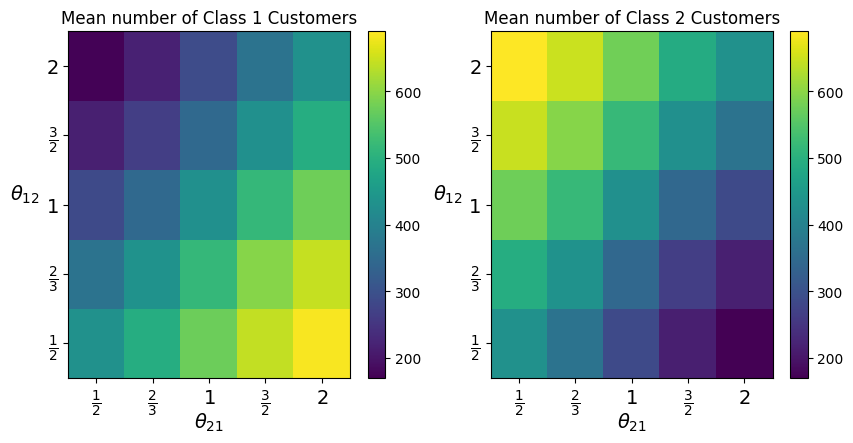

In [4]:
theta_names = [r"$\frac{1}{2}$", r"$\frac{2}{3}$", r"$1$", r"$\frac{3}{2}$", r"$2$"]
cross_df1 = data.groupby(['theta_12', 'theta_21'])['mean_custs_1'].mean().unstack()
cross_df2 = data.groupby(['theta_12', 'theta_21'])['mean_custs_2'].mean().unstack()

fig, axarr = plt.subplots(1, 2, figsize=(10, 4.5))
vmin = min(np.floor(cross_df1.min().min() / 10) * 10, np.floor(cross_df2.min().min() / 10) * 10)
vmax = max(np.ceil(cross_df1.max().max() / 10) * 10, np.ceil(cross_df2.max().max() / 10) * 10)

c = axarr[0].pcolor(cross_df1, vmin=vmin, vmax=vmax)
axarr[0].set_yticks(np.arange(0.5, len(cross_df1.index), 1), theta_names, fontsize=14)
axarr[0].set_xticks(np.arange(0.5, len(cross_df1.columns), 1), theta_names, fontsize=14)
axarr[0].set_xlabel(r"$\theta_{21}$", fontsize=14, labelpad=-5)
axarr[0].set_ylabel(r"$\theta_{12}$", fontsize=14, rotation=0, labelpad=15)

axarr[1].pcolor(cross_df2, vmin=vmin, vmax=vmax)
axarr[1].set_yticks(np.arange(0.5, len(cross_df2.index), 1), theta_names, fontsize=14)
axarr[1].set_xticks(np.arange(0.5, len(cross_df2.columns), 1), theta_names, fontsize=14)
axarr[1].set_xlabel(r"$\theta_{21}$", fontsize=14, labelpad=-5)
axarr[1].set_ylabel(r"$\theta_{12}$", fontsize=14, rotation=0, labelpad=15)

axarr[0].set_title("Mean number of Class 1 Customers")
axarr[1].set_title("Mean number of Class 2 Customers")

fig.colorbar(c, ax=axarr[0])
fig.colorbar(c, ax=axarr[1])

plt.show()

In [5]:
qs = [0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
adf_comparison = pd.DataFrame({
    'Check False': np.quantile(data[data['outcome']==False]['adf_pvalue'], q=qs).round(5),
    'Check True': np.quantile(data[data['outcome']==True]['adf_pvalue'], q=qs).round(5)
    }, index=qs
)
adf_comparison.index.name = 'Quantile'
adf_comparison

,Check False,Check True
Quantile,,
0.00,0.00000,0.00000
0.05,0.09159,0.00000
0.10,0.24669,0.00000
0.25,0.67206,0.00000
0.50,0.92977,0.00000
0.75,0.98590,0.00000
1.00,1.00000,0.00056


In [6]:
pvals = [0.001, 0.005, 0.01, 0.05, 0.1]
adf_comparison = pd.DataFrame({
    'Check False': [round((data[data['outcome']==False]['adf_pvalue'] < p).mean() * 100, 2) for p in pvals],
    'Check True': [round((data[data['outcome']==True]['adf_pvalue'] < p).mean() * 100, 2) for p in pvals]
}, index=pvals)
adf_comparison.index.name = 'p-Value Threshold'
adf_comparison

,Check False,Check True
p-Value Threshold,,
0.001,0.75,100.0
0.005,1.25,100.0
0.010,1.44,100.0
0.050,3.38,100.0
0.100,5.25,100.0


In [7]:
data['max_traffic_intensity'] = (data['lambda_1'] + data['lambda_2']) / (data['num_servers'] * data[['mu_1', 'mu_2']].min(axis=1))
data['min_traffic_intensity'] = (data['lambda_1'] + data['lambda_2']) / (data['num_servers'] * data[['mu_1', 'mu_2']].max(axis=1))
data['theta_diff'] = data['theta_12'] - data['theta_21']

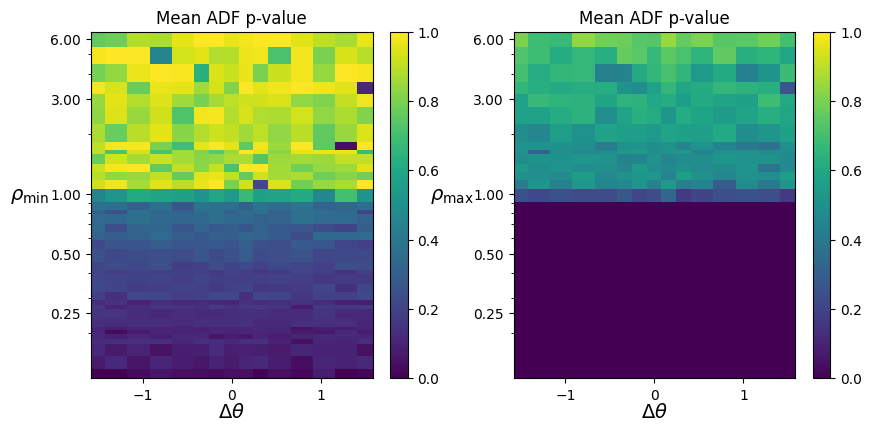

In [8]:
min_rho_crossref = data.groupby(['min_traffic_intensity', 'theta_diff'])['adf_pvalue'].mean().unstack()
max_rho_crossref = data.groupby(['max_traffic_intensity', 'theta_diff'])['adf_pvalue'].mean().unstack()

fig, axarr = plt.subplots(1, 2, figsize=(10, 4.5))

c = axarr[0].pcolor(min_rho_crossref.columns, min_rho_crossref.index, min_rho_crossref, vmin=0, vmax=1)
axarr[0].set_xlabel(r"$\Delta\theta$", fontsize=14, labelpad=0)
axarr[0].set_ylabel(r"$\rho_{\min}$", fontsize=14, rotation=0, labelpad=15)
fig.colorbar(c, ax=axarr[0])
axarr[0].set_yscale('log')
axarr[0].set_yticks([0.25, 0.5, 1, 3, 6])
axarr[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axarr[0].set_title("Mean ADF p-value")

c = axarr[1].pcolor(max_rho_crossref.columns, max_rho_crossref.index, max_rho_crossref, vmin=0, vmax=1)
axarr[1].set_xlabel(r"$\Delta\theta$", fontsize=14, labelpad=0)
axarr[1].set_ylabel(r"$\rho_{\max}$", fontsize=14, rotation=0, labelpad=15)
fig.colorbar(c, ax=axarr[1])
axarr[1].set_yscale('log')
axarr[1].set_yticks([0.25, 0.5, 1, 3, 6])
axarr[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axarr[1].set_title("Mean ADF p-value")

fig.savefig('../../tex/img/mean_adf.pdf')

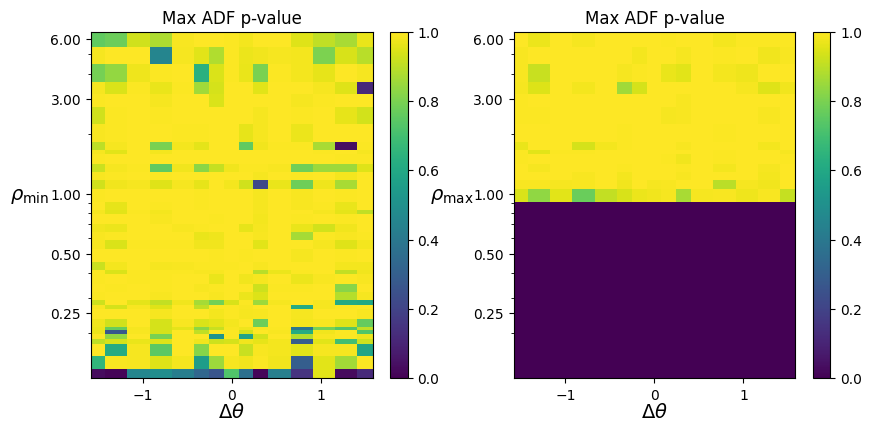

In [9]:
min_rho_crossref = data.groupby(['min_traffic_intensity', 'theta_diff'])['adf_pvalue'].max().unstack()
max_rho_crossref = data.groupby(['max_traffic_intensity', 'theta_diff'])['adf_pvalue'].max().unstack()

fig, axarr = plt.subplots(1, 2, figsize=(10, 4.5))

c = axarr[0].pcolor(min_rho_crossref.columns, min_rho_crossref.index, min_rho_crossref, vmin=0, vmax=1)
axarr[0].set_xlabel(r"$\Delta\theta$", fontsize=14, labelpad=0)
axarr[0].set_ylabel(r"$\rho_{\min}$", fontsize=14, rotation=0, labelpad=15)
fig.colorbar(c, ax=axarr[0])
axarr[0].set_yscale('log')
axarr[0].set_yticks([0.25, 0.5, 1, 3, 6])
axarr[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axarr[0].set_title("Max ADF p-value")

c = axarr[1].pcolor(max_rho_crossref.columns, max_rho_crossref.index, max_rho_crossref, vmin=0, vmax=1)
axarr[1].set_xlabel(r"$\Delta\theta$", fontsize=14, labelpad=0)
axarr[1].set_ylabel(r"$\rho_{\max}$", fontsize=14, rotation=0, labelpad=15)
fig.colorbar(c, ax=axarr[1])
axarr[1].set_yscale('log')
axarr[1].set_yticks([0.25, 0.5, 1, 3, 6])
axarr[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axarr[1].set_title("Max ADF p-value")

fig.savefig('../../tex/img/max_adf.pdf')

In [10]:
data

,id_number,max_simulation_time,warmup_time,cooldown_time,num_classes,lambda_1,lambda_2,mu_1,mu_2,theta_12,...,prob_empty_2,prob_empty_overall,mean_sojourn_1,mean_sojourn_2,mean_sojourn_overall,outcome,adf_pvalue,max_traffic_intensity,min_traffic_intensity,theta_diff
0,964ab4da09f6bd3c1c3c7c835391a38f,5000.0,200.0,200.0,2,1.0,0.5,0.5,0.5,0.500000,...,0.0,0.0,607.500944,NaN,607.500944,False,0.995176,1.5,1.50,0.000000
1,ced976ecaf1f908c882ef5d838cd0bae,5000.0,200.0,200.0,2,1.0,0.5,0.5,0.5,0.666667,...,0.0,0.0,621.782172,NaN,621.782172,False,0.990347,1.5,1.50,0.166667
2,e1808842b47368c8208b24dfddde85b9,5000.0,200.0,200.0,2,1.0,0.5,0.5,0.5,0.500000,...,0.0,0.0,664.547036,NaN,664.547036,False,0.518966,1.5,1.50,-0.166667
3,6b48e5f6d00b6d58ae68adc026eba414,5000.0,200.0,200.0,2,1.0,0.5,0.5,0.5,0.666667,...,0.0,0.0,613.988664,NaN,613.988664,False,0.995618,1.5,1.50,0.000000
4,1e601d4650dd878c637c2d501c561647,5000.0,200.0,200.0,2,1.0,0.5,0.5,0.5,1.000000,...,0.0,0.0,684.885222,NaN,684.885222,False,0.346269,1.5,1.50,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,749ae63c1ca68f4a41fc63e2570790ad,5000.0,200.0,200.0,2,1.0,2.0,1.0,3.0,1.500000,...,0.0,0.0,1071.265872,NaN,1071.265872,False,0.219311,3.0,1.00,0.000000
9371,cf40b48fde9ee8fb9e26a6c86e0a92cd,5000.0,200.0,200.0,2,1.0,2.0,1.0,3.0,2.000000,...,0.0,0.0,1023.050063,NaN,1023.050063,False,0.999082,3.0,1.00,0.500000
9372,ab78e8583d86ccf6506ddc3bfd3a1eaf,5000.0,200.0,200.0,2,1.0,2.0,1.0,4.0,1.500000,...,0.0,0.0,1071.265872,NaN,1071.265872,NaN,0.219311,3.0,0.75,0.000000
9373,f082bf73d502db7b16b48449e2485f8e,5000.0,200.0,200.0,2,1.0,2.0,1.0,4.0,2.000000,...,0.0,0.0,1023.050063,NaN,1023.050063,NaN,0.999082,3.0,0.75,0.500000


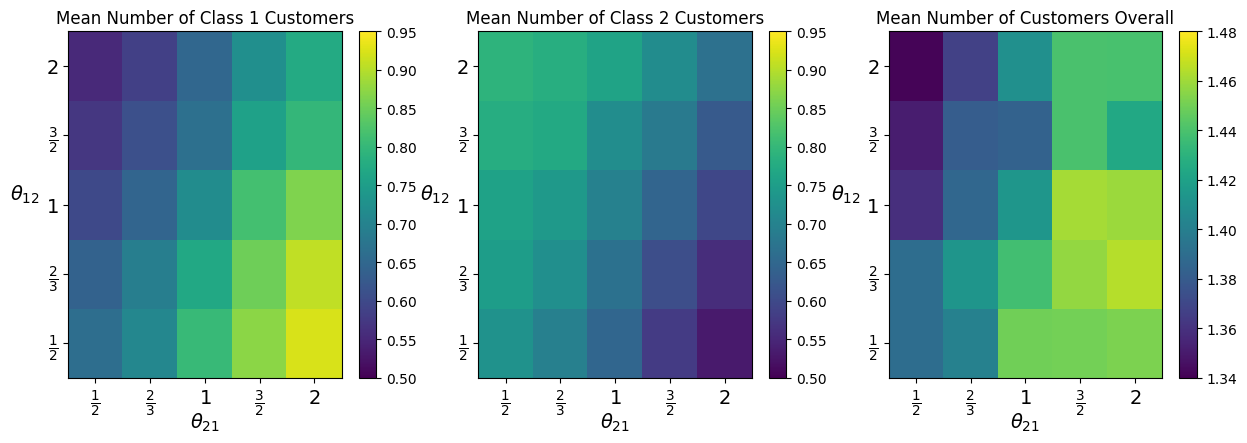

In [38]:
theta_names = [r"$\frac{1}{2}$", r"$\frac{2}{3}$", r"$1$", r"$\frac{3}{2}$", r"$2$"]
cross_df1 = data[data['max_traffic_intensity']<1].groupby(['theta_12', 'theta_21'])['mean_custs_1'].mean().unstack()
cross_df2 = data[data['max_traffic_intensity']<1].groupby(['theta_12', 'theta_21'])['mean_custs_2'].mean().unstack()
cross_df3 = cross_df1 + cross_df2

fig, axarr = plt.subplots(1, 3, figsize=(15, 4.5))
vmin = min(np.floor(cross_df1.min().min() * 20) / 20, np.floor(cross_df2.min().min() * 20) / 20)
vmax = max(np.ceil(cross_df1.max().max() * 20) / 20, np.ceil(cross_df2.max().max() * 20) / 20)

vmin_o = np.floor(cross_df3.min().min() * 50) / 50
vmax_o = np.ceil(cross_df3.max().max() * 50) / 50

c = axarr[0].pcolor(cross_df1, vmin=vmin, vmax=vmax)
axarr[0].set_yticks(np.arange(0.5, len(cross_df1.index), 1), theta_names, fontsize=14)
axarr[0].set_xticks(np.arange(0.5, len(cross_df1.columns), 1), theta_names, fontsize=14)
axarr[0].set_xlabel(r"$\theta_{21}$", fontsize=14, labelpad=-5)
axarr[0].set_ylabel(r"$\theta_{12}$", fontsize=14, rotation=0, labelpad=15)

axarr[1].pcolor(cross_df2, vmin=vmin, vmax=vmax)
axarr[1].set_yticks(np.arange(0.5, len(cross_df2.index), 1), theta_names, fontsize=14)
axarr[1].set_xticks(np.arange(0.5, len(cross_df2.columns), 1), theta_names, fontsize=14)
axarr[1].set_xlabel(r"$\theta_{21}$", fontsize=14, labelpad=-5)
axarr[1].set_ylabel(r"$\theta_{12}$", fontsize=14, rotation=0, labelpad=15)

c_o = axarr[2].pcolor(cross_df3, vmin=vmin_o, vmax=vmax_o)
axarr[2].set_yticks(np.arange(0.5, len(cross_df2.index), 1), theta_names, fontsize=14)
axarr[2].set_xticks(np.arange(0.5, len(cross_df2.columns), 1), theta_names, fontsize=14)
axarr[2].set_xlabel(r"$\theta_{21}$", fontsize=14, labelpad=-5)
axarr[2].set_ylabel(r"$\theta_{12}$", fontsize=14, rotation=0, labelpad=15)

axarr[0].set_title("Mean Number of Class 1 Customers")
axarr[1].set_title("Mean Number of Class 2 Customers")
axarr[2].set_title("Mean Number of Customers Overall")

fig.colorbar(c, ax=axarr[0])
fig.colorbar(c, ax=axarr[1])
fig.colorbar(c_o, ax=axarr[2])

fig.savefig('../../tex/img/theta_effect_cust_numbers.pdf')

In [18]:
cross_df1

theta_21,0.500000,0.666667,1.000000,1.500000,2.000000
theta_12,,,,,
0.500000,0.660204,0.707606,0.803174,0.872635,0.921938
0.666667,0.640325,0.691461,0.769145,0.850835,0.907494
1.000000,0.600174,0.644715,0.717941,0.815595,0.863613
1.500000,0.570462,0.609435,0.664950,0.755578,0.797643
2.000000,0.551554,0.585815,0.648131,0.722097,0.772738


In [19]:
cross_df2

theta_21,0.500000,0.666667,1.000000,1.500000,2.000000
theta_12,,,,,
0.500000,0.729054,0.693581,0.646403,0.577554,0.530498
0.666667,0.749031,0.721669,0.668250,0.606530,0.557110
1.000000,0.758935,0.741602,0.695727,0.645780,0.595095
1.500000,0.780753,0.771399,0.718620,0.683998,0.626372
2.000000,0.790070,0.781507,0.761810,0.717453,0.666572


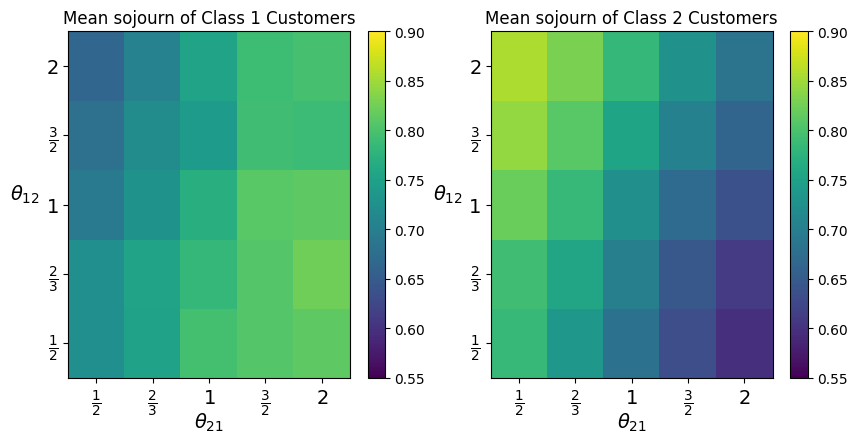

In [12]:
theta_names = [r"$\frac{1}{2}$", r"$\frac{2}{3}$", r"$1$", r"$\frac{3}{2}$", r"$2$"]
cross_df1 = data[data['max_traffic_intensity']<1].groupby(['theta_12', 'theta_21'])['mean_sojourn_1'].mean().unstack()
cross_df2 = data[data['max_traffic_intensity']<1].groupby(['theta_12', 'theta_21'])['mean_sojourn_2'].mean().unstack()

fig, axarr = plt.subplots(1, 2, figsize=(10, 4.5))
vmin = min(np.floor(cross_df1.min().min() * 20) / 20, np.floor(cross_df2.min().min() * 20) / 20)
vmax = max(np.ceil(cross_df1.max().max() * 20) / 20, np.ceil(cross_df2.max().max() * 20) / 20)

c = axarr[0].pcolor(cross_df1, vmin=vmin, vmax=vmax)
axarr[0].set_yticks(np.arange(0.5, len(cross_df1.index), 1), theta_names, fontsize=14)
axarr[0].set_xticks(np.arange(0.5, len(cross_df1.columns), 1), theta_names, fontsize=14)
axarr[0].set_xlabel(r"$\theta_{21}$", fontsize=14, labelpad=-5)
axarr[0].set_ylabel(r"$\theta_{12}$", fontsize=14, rotation=0, labelpad=15)

axarr[1].pcolor(cross_df2, vmin=vmin, vmax=vmax)
axarr[1].set_yticks(np.arange(0.5, len(cross_df2.index), 1), theta_names, fontsize=14)
axarr[1].set_xticks(np.arange(0.5, len(cross_df2.columns), 1), theta_names, fontsize=14)
axarr[1].set_xlabel(r"$\theta_{21}$", fontsize=14, labelpad=-5)
axarr[1].set_ylabel(r"$\theta_{12}$", fontsize=14, rotation=0, labelpad=15)

axarr[0].set_title("Mean sojourn of Class 1 Customers")
axarr[1].set_title("Mean sojourn of Class 2 Customers")

fig.colorbar(c, ax=axarr[0])
fig.colorbar(c, ax=axarr[1])

fig.savefig('../../tex/img/theta_effect_sojourn_times.pdf')